In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

458011/458011 [==============================] - 0s 0us/step


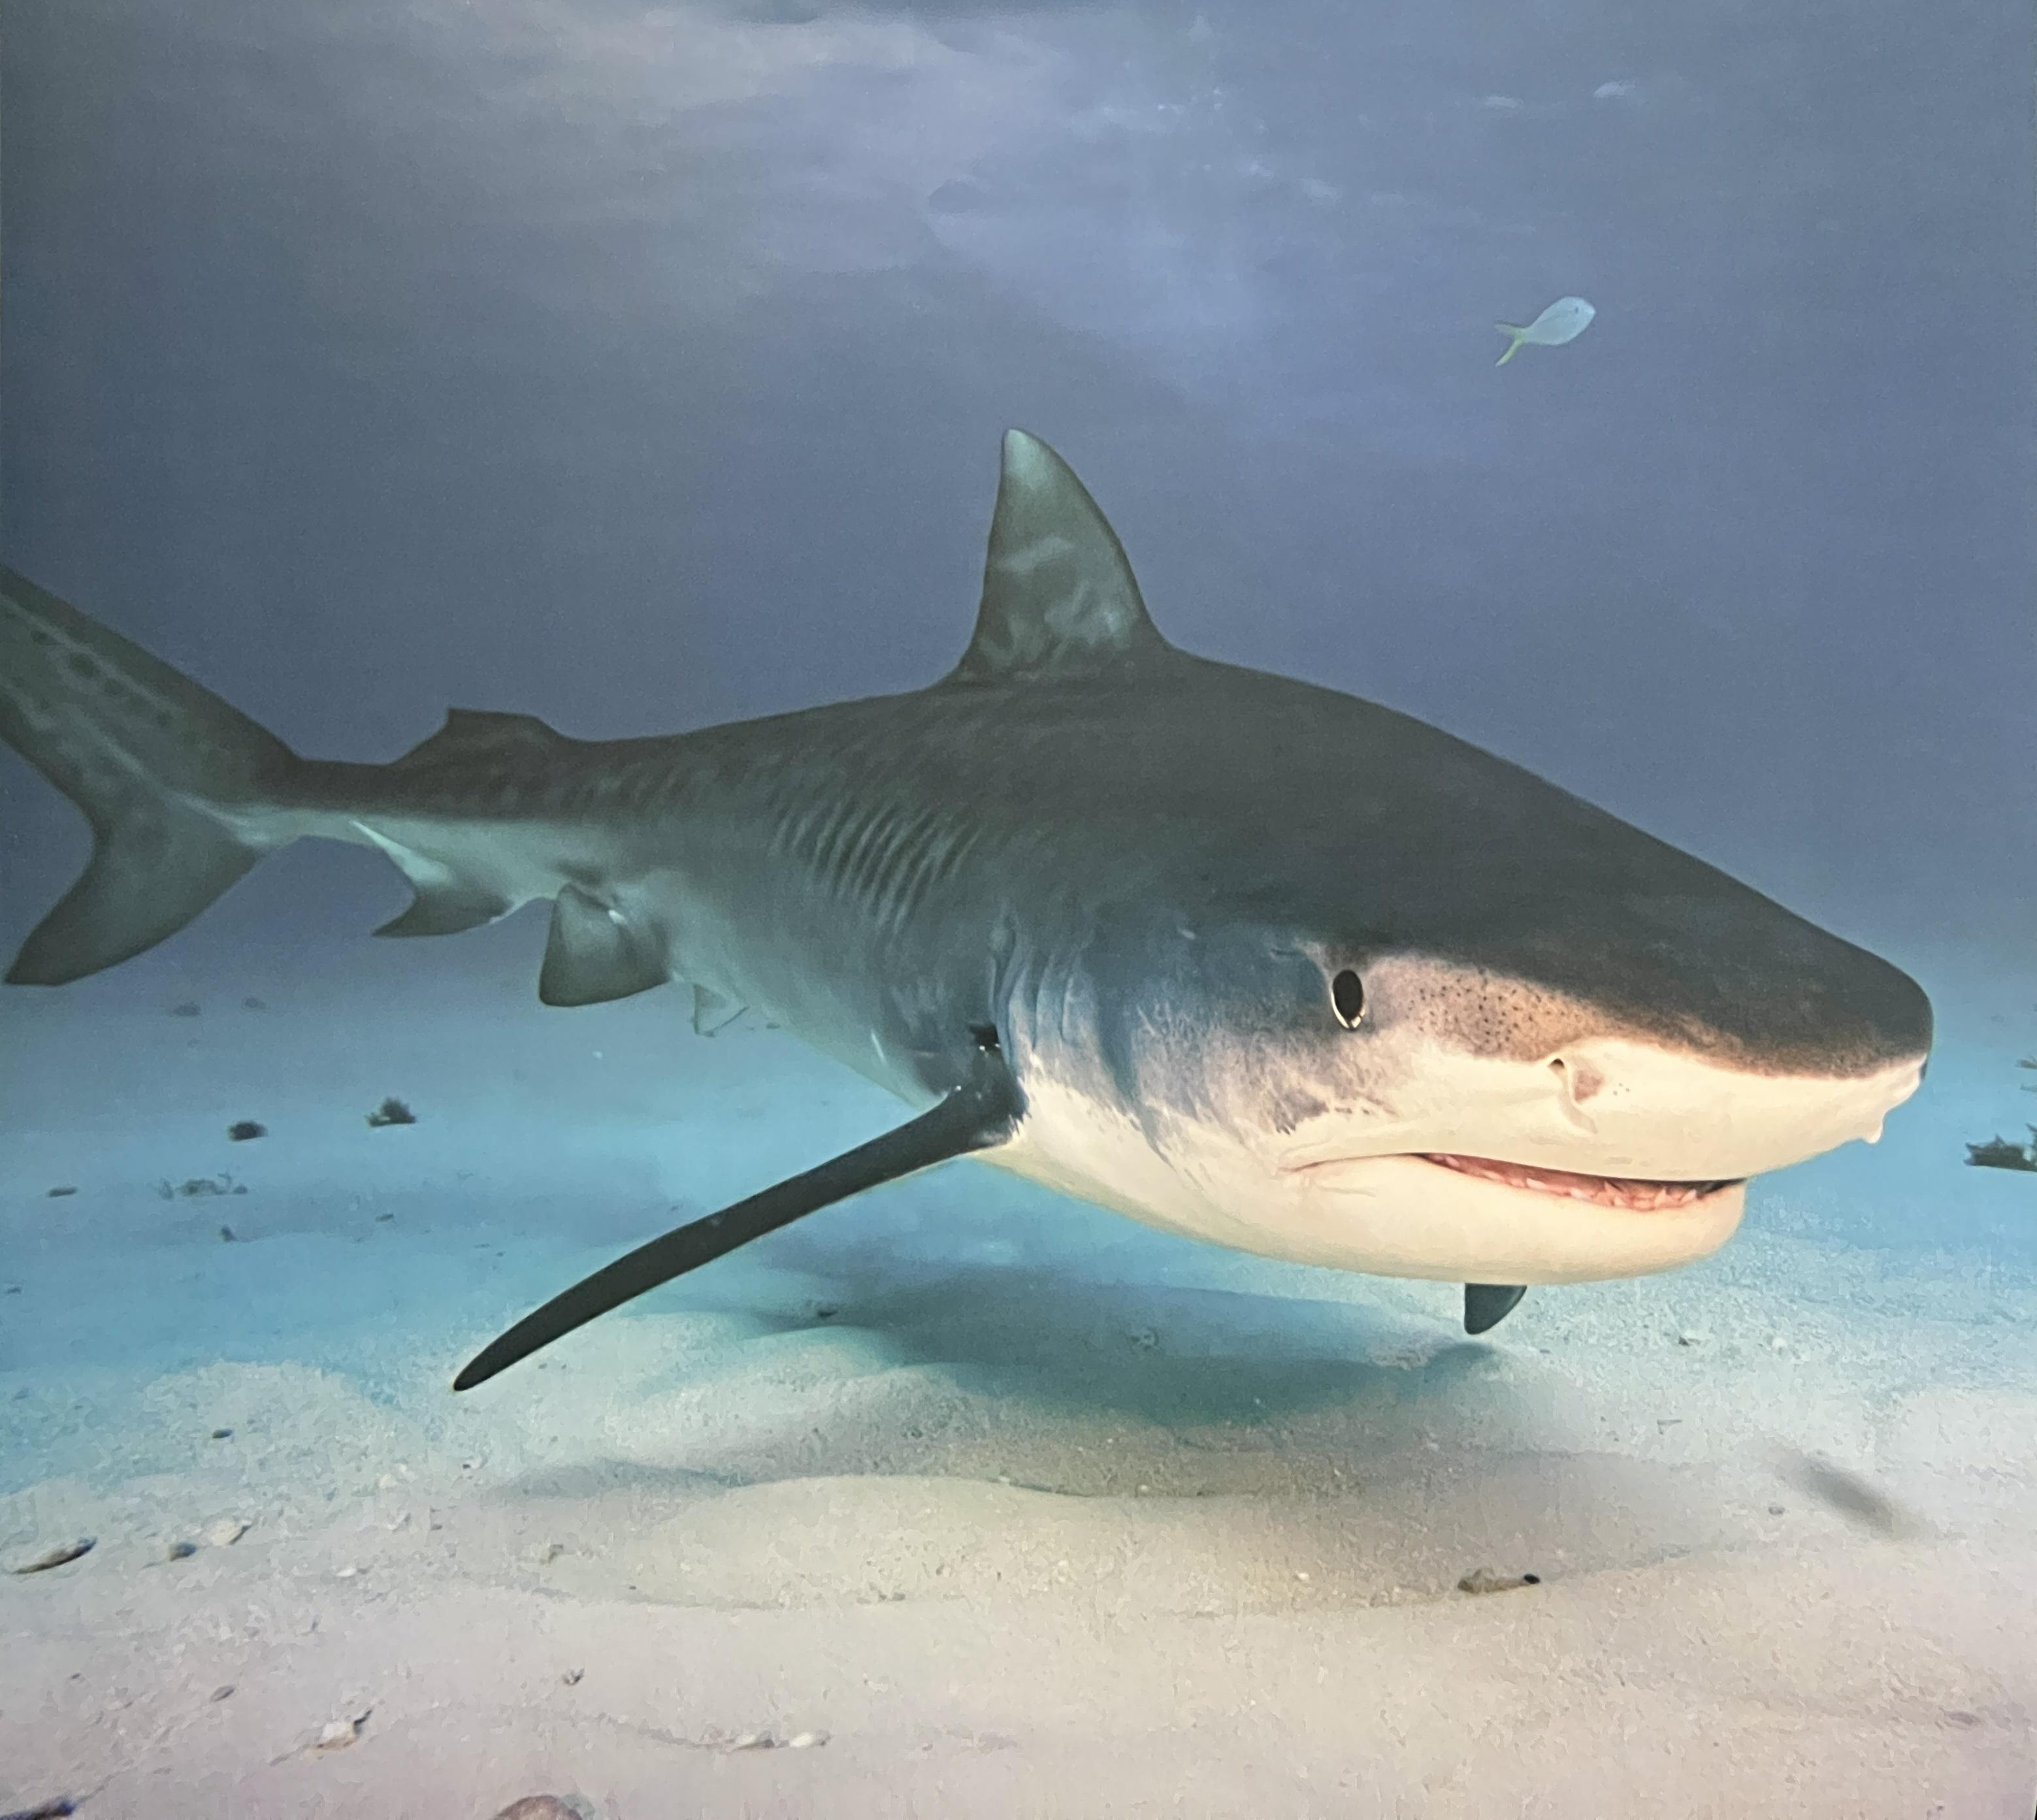

In [3]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "https://i.imgur.com/1Phh6hv.jpeg")

In [4]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

35363/35363 [==============================] - 0s 0us/step
The predicted class is : tiger_shark


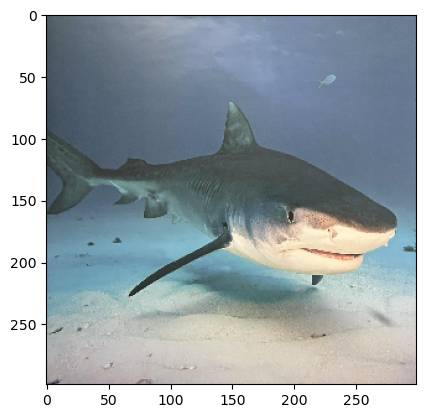

In [5]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

In [6]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

1/1 [==============================] - 0s 222ms/step
tiger_shark
great_white_shark
hammerhead
scuba_diver
sturgeon


In [7]:
explainer = lime_image.LimeImageExplainer()

In [8]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


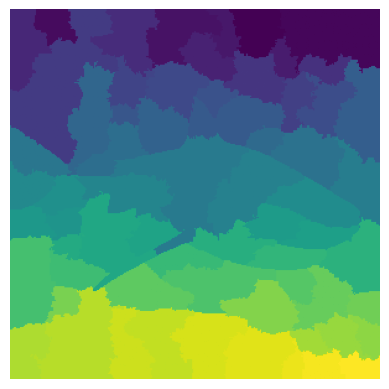

In [9]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [10]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

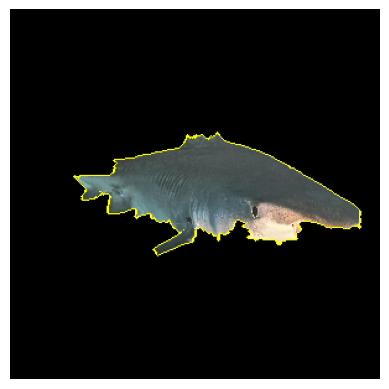

In [11]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

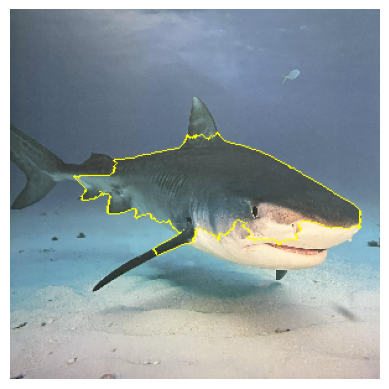

In [12]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

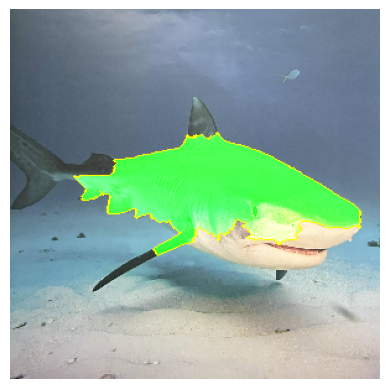

In [13]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

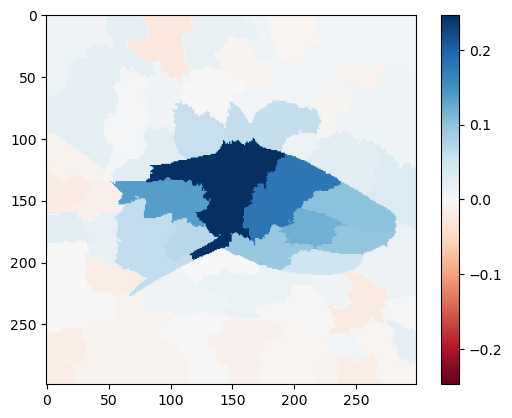

In [14]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

In [15]:
index = 2
print(f"We will deal with predicted class: {top5_pred[index][1]}")

We will deal with predicted class: hammerhead


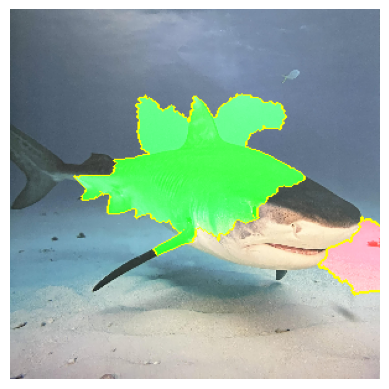

In [16]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)

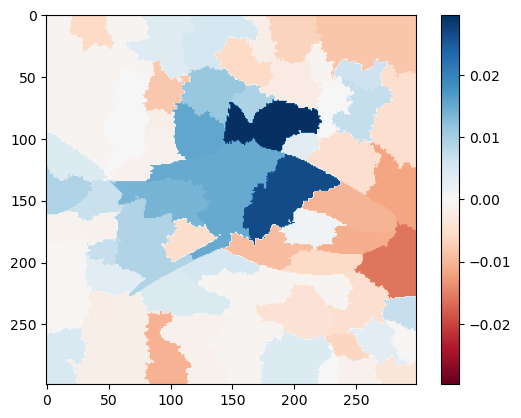

In [17]:
explanation_heatmap(exp, exp.top_labels[index])